### **Semantic Math Types from unstructured text**

This is an overview of the Mathematics Stack Exchange Dataset and a showroom for semantic annotations of mathematical expressions

In [1]:
from mse_db import MSE_DBS # provides an interface for interaction with a local MongoDB instance
import funcs               # provides data processing functions
from sem_math import PostThread, \
                     FormulaContextType, \
                     FormulaType, \
                     Comparer
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

The PostThread class encapsulates one question post and all corresponding answers. The three other classes (FormulaContextType, FormulaType and Comparer) are used to determine a semantic type.

#### **1. Dataset Overview**

The basic unit of the processed MSE dataset is a PostThread instance which includes one question post and all corresponding answer posts. All of these are stored within the **posts** attribute. 

![Post Thread Entry in DB](<images/post_thread_entry.png>)

A **post** entry includes general post metadata, as well as a set of tags and a **PostTypeId** which has the value 1 for question posts and a value of 2 for answer posts.

![](images/post_entry.png)

In [2]:
log_file_name = "conf\log.txt"                          # processing log
db_settings_file_name = "conf\db_conf.json"             # settings file for the database connection (local)

data = MSE_DBS(db_settings_file_name, log_file_name) 
total_count = data.apply_once("threads", funcs.count_all_post_threads_once)      # counts all documents in threads collection -> ENTIRE DATASET
print("ENTIRE dataset has {} post-threads".format(total_count))
data.reset_count()

ENTIRE dataset has 1502850 post-threads


In [3]:
sel_coll_names = ["algebra-precalculus", "analytic-geometry", "elementary-functions", "elementary-number-theory", \
                  "elementary-set-theory", "euclidean-geometry", "trigonometry"]

sel_data_size = 0
for coll in sel_coll_names:
    coll_size = data.apply_once(coll, funcs.count_all_post_threads_once)
    posts_len, posts_av = data.apply_once(coll, funcs.count_av_all_posts_once)  
    print("\"{}\": {} post-threads, number of posts: {} , average: {:.2f}".format(coll,coll_size, posts_len, posts_av))
    sel_data_size += coll_size

print("\n")
print("{} post-threads".format(sel_data_size))
print("selected data is {:.2f} % of ENTIRE dataset".format(100* (sel_data_size/total_count)))

"algebra-precalculus": 43604 post-threads, number of posts: 126404 , average: 2.90
"analytic-geometry": 5934 post-threads, number of posts: 14297 , average: 2.41
"elementary-functions": 515 post-threads, number of posts: 1225 , average: 2.38
"elementary-number-theory": 34454 post-threads, number of posts: 90098 , average: 2.62
"elementary-set-theory": 26535 post-threads, number of posts: 66175 , average: 2.49
"euclidean-geometry": 8188 post-threads, number of posts: 19052 , average: 2.33
"trigonometry": 27356 post-threads, number of posts: 75653 , average: 2.77


146586 post-threads
selected data is 9.75 % of ENTIRE dataset


The project will be using only this subset of data because it is sufficiently large to demonstrate a working prototype and because questions and answers from the selected categories include the most common and widely used mathematical types and notations.

#### **2. Formula Occurence**

The **Post Thread** entry also includes a formulas attribute, which is a list of all extracted formulas / mathematical expressions. Each formula entry has an **id**, and a **latex string**, but also a **mathematical type**, a **relevant string** (if found) that describes the value and a **decision string** that explains how the program determined the type.

![Formula Entry in DB](images/formulas_entry.PNG)


In [4]:
sel_coll_names = ["algebra-precalculus", "analytic-geometry", "elementary-functions", "elementary-number-theory", \
                  "elementary-set-theory", "euclidean-geometry", "trigonometry"]

sel_formulas_total = 0
formula_counts_list = []
for coll in sel_coll_names:
    num_formulas = data.apply_once(coll, funcs.count_all_formulas_once)
    av_formulas = data.apply_once(coll, funcs.formulas_av_once)  
    formula_counts_list.append(num_formulas)
    print("\"{}\": {} formulas , average: {:.2f} ".format(coll,num_formulas, av_formulas))
    sel_formulas_total += num_formulas

print("\n")
print("selected data has a total of {} formulas".format(sel_formulas_total))

"algebra-precalculus": 1014466 formulas , average: 23.27 
"analytic-geometry": 145334 formulas , average: 24.49 
"elementary-functions": 11125 formulas , average: 21.60 
"elementary-number-theory": 1144251 formulas , average: 33.21 
"elementary-set-theory": 715175 formulas , average: 26.95 
"euclidean-geometry": 224931 formulas , average: 27.47 
"trigonometry": 565353 formulas , average: 20.67 


selected data has a total of 3820635 formulas


#### **3. Semantic Types Extraction**

In [5]:
def plot_types(labels, val_lists, types, title_str):

    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    width = 0.5 

    sums = [0 for i in range(len(val_lists[0]))]
    for i in range(len(val_lists)):
        if not i == 0:
            sums = [ v1 + v2 for v1, v2 in zip(sums, val_lists[i-1])]
        ax.bar(labels, val_lists[i], width, label=types[i], bottom=sums)
   
    y_formatter = ScalarFormatter(useOffset=False)
    y_formatter.set_scientific(False)
    ax.yaxis.set_major_formatter(y_formatter)
    ax.set_ylabel('Absolute numbers')
    ax.set_title(title_str)
    ax.legend()
    plt.show()

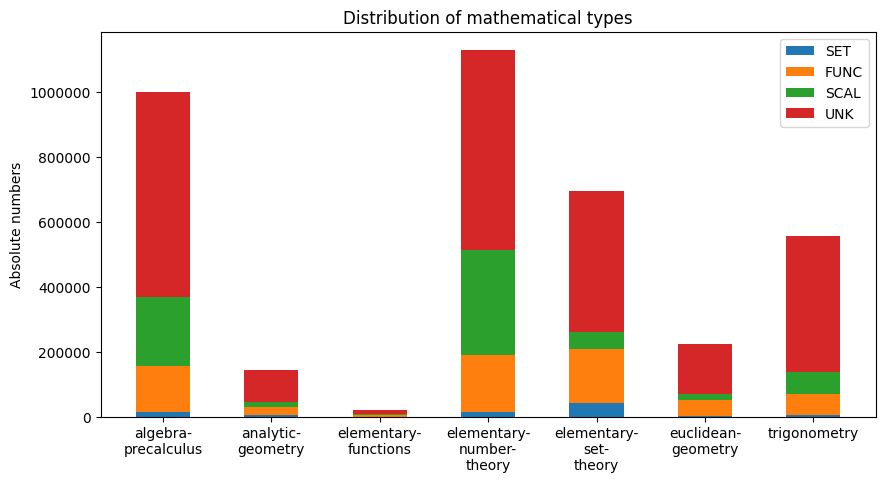

In [6]:
sel_coll_names = ["algebra-precalculus", "analytic-geometry", "elementary-functions", "elementary-number-theory", \
                  "elementary-set-theory", "euclidean-geometry", "trigonometry"]

sel_coll_labels = ["algebra-\nprecalculus", "analytic-\ngeometry", "elementary-\nfunctions", "elementary-\nnumber-\ntheory", \
                  "elementary-\nset-\ntheory", "euclidean-\ngeometry", "trigonometry"]
                  
m_type_labels  = ["SET", "FUNC", "SCAL", "UNK"]
translation_dict = { "TypeFormulaCount": "formula", \
                     "TypeBothCount": "both", \
                     "TypeContextCount": "context", \
                     "TypeContextR2Count": "context-rule 2"}

categories = list(translation_dict.values())
vals_list = []
for t_label in m_type_labels:
    t_all_counts_list = []
    for coll in sel_coll_names:
        type_count_dict = data.apply_once(coll, funcs.count_m_type_occurences_once, {"m_type": t_label})
        type_count_total = type_count_dict["TypeBothCount"] + \
                           type_count_dict["TypeContextCount"] + \
                           type_count_dict["TypeContextR2Count"] + \
                           type_count_dict["TypeFormulaCount"]
        t_all_counts_list.append(type_count_total)
    vals_list.append(t_all_counts_list)

title_str = "Distribution of mathematical types"

plot_types(sel_coll_labels, vals_list, m_type_labels, title_str)

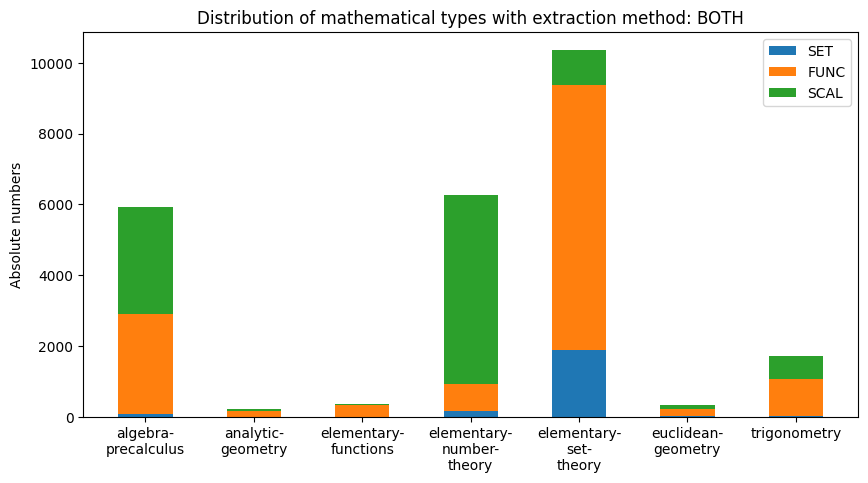

In [24]:
vals_list = []
for t_label in m_type_labels:
    t_all_counts_list = []
    for coll in sel_coll_names:
        type_count_dict = data.apply_once(coll, funcs.count_m_type_occurences_once, {"m_type": t_label})
        type_count_total = type_count_dict["TypeBothCount"] 
        t_all_counts_list.append(type_count_total)
    vals_list.append(t_all_counts_list)

title_str = "Distribution of mathematical types with extraction method: BOTH"

plot_types(sel_coll_labels, vals_list, m_type_labels, title_str)

The bar chart shows the proportions of identified mathematical types across different categories. About 30 % of types were identified (the rest has been assigned the UNK type.)

In [25]:
def get_determining_f_data(type_str, sel_coll_names, categories):
    vals_list = [[] for cat in categories]
    for coll in sel_coll_names:
        coll = coll.replace("\n", "")
        type_count_dict = data.apply_once(coll, funcs.count_m_type_occurences_once, {"m_type": type_str})
        vals_list[3].append(type_count_dict["TypeBothCount"])
        vals_list[1].append(type_count_dict["TypeContextCount"])
        vals_list[2].append(type_count_dict["TypeContextR2Count"])
        vals_list[0].append(type_count_dict["TypeFormulaCount"])

    return vals_list

In [26]:
def plot_subplot(fig, subplot_counter, val_lists, title_str, types, labels):
    ax = fig.add_subplot(subplot_counter)
    width = 0.5 

    sums = [0 for i in range(len(val_lists[0]))]
    for i in range(len(val_lists)):
        if not i == 0:
            sums = [ v1 + v2 for v1, v2 in zip(sums, val_lists[i-1])]
        ax.bar(labels, val_lists[i], width, label=types[i], bottom=sums)
   
    y_formatter = ScalarFormatter(useOffset=False)
    y_formatter.set_scientific(False)
    ax.yaxis.set_major_formatter(y_formatter)
    ax.set_ylabel('Absolute numbers')
    ax.set_title(title_str)
    ax.legend()

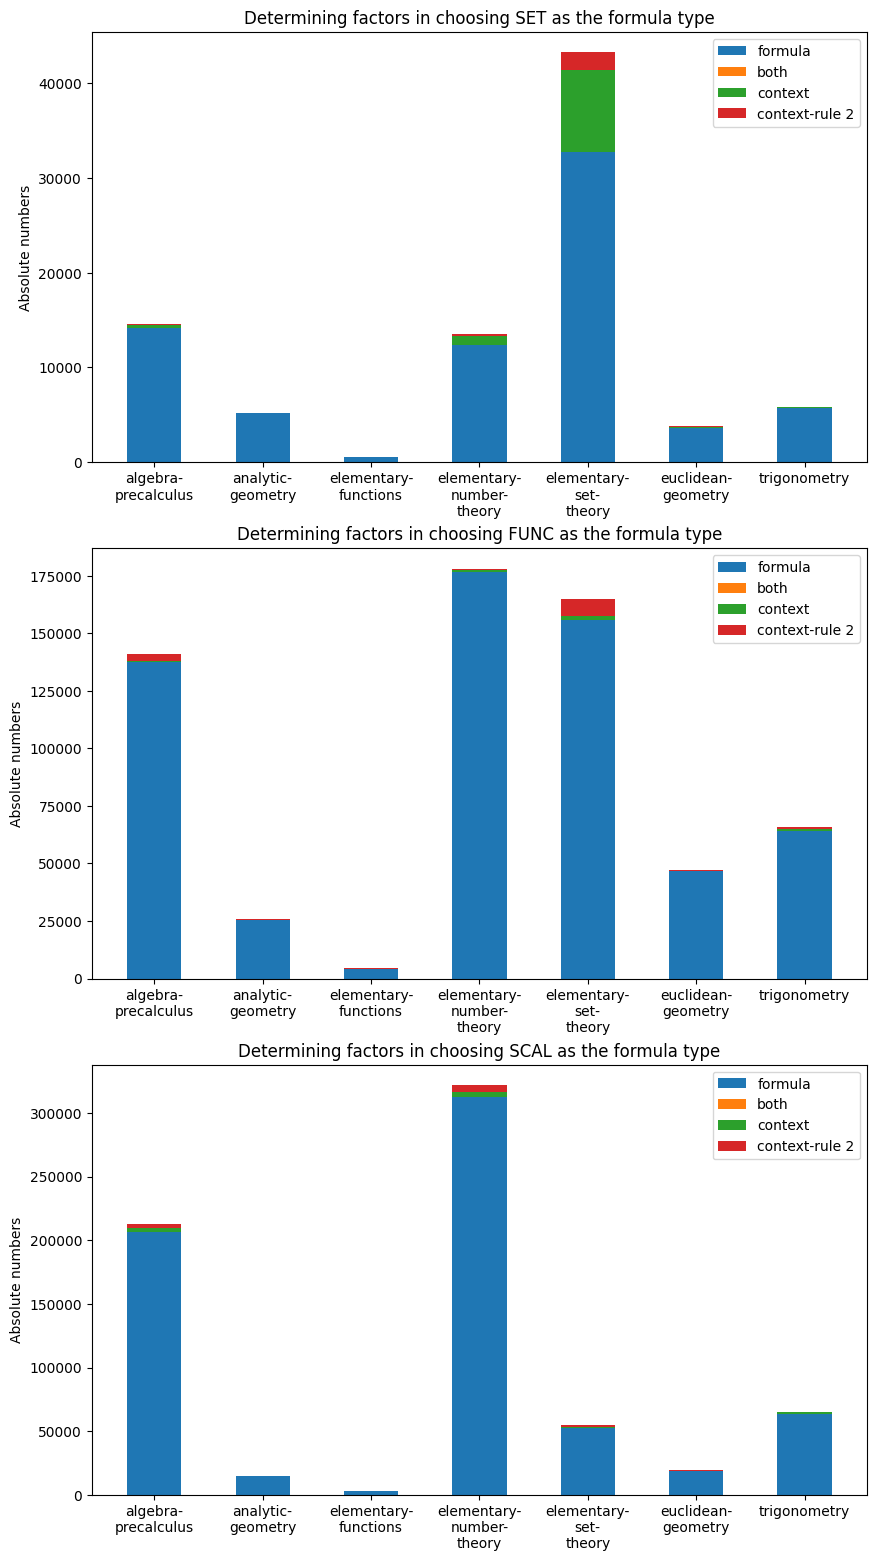

In [28]:
def plot_determining_factors(m_type_labels, sel_coll_names, categories, figure_size):

    type_num = len(m_type_labels)
    subplot_counter = 100 * type_num + 10

    fig = plt.figure(figsize=figure_size)
    for m_type_str in m_type_labels:
        subplot_counter += 1
        title_str = "Determining factors in choosing " +  m_type_str + " as the formula type"

        vals_list = get_determining_f_data(m_type_str, sel_coll_names, categories)
        plot_subplot(fig, subplot_counter, vals_list, title_str, categories, sel_coll_names)

    plt.subplots_adjust()
    plt.show()

figure_size = (10,19)
m_type_labels = ["SET", "FUNC", "SCAL"]
plot_determining_factors(m_type_labels, sel_coll_labels, categories, figure_size)